# Predict Nvidia stock based on four basic models: Single-layer LSTM, Two-layer LSTM, RNN, and GRU

# step 1: Import related libraries

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

# step 2: Data loading and preprocessing

In [19]:
# 2.1: Data Input - Local Upload
file_path = '/content/sorted_NVIDIA.csv'
data = pd.read_csv(file_path)
data['Close/Last'] = data['Close/Last'].str.replace('$', '').str.strip().astype(float)
print(data.head())


         Date  Close/Last
0  2020-01-27        6.01
1  2020-01-28        6.20
2  2020-01-29        6.14
3  2020-01-30        6.15
4  2020-01-31        5.91


In [20]:
close_prices = data['Close/Last'].values.reshape(-1, 1)
# Normalize the close price using the minmax normalization method
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [21]:
# 2.2: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 150  # Use last 150 days to predict the next day
X, y = create_sequences(scaled_data, time_steps)

# Split into training, testing and validation sets

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def calculate_test_loss_sequence(model, X_test, y_test, history):
    test_loss = []
    for i in range(len(history.history['loss'])):
        weights = model.get_weights()
        test_pred = model.predict(X_test, verbose=0)
        test_loss.append(mean_squared_error(y_test, test_pred))
    return test_loss

data['Date'] = pd.to_datetime(data['Date'])
test_dates = data['Date'].values[-len(y_test):]
val_dates = data['Date'].values[-len(y_val) - len(y_test):-len(y_test)]

print(pd.DataFrame(test_dates))
print(pd.DataFrame(val_dates))

             0
0   2024-05-24
1   2024-05-28
2   2024-05-29
3   2024-05-30
4   2024-05-31
..         ...
162 2025-01-17
163 2025-01-21
164 2025-01-22
165 2025-01-23
166 2025-01-24

[167 rows x 1 columns]
             0
0   2023-09-27
1   2023-09-28
2   2023-09-29
3   2023-10-02
4   2023-10-03
..         ...
161 2024-05-17
162 2024-05-20
163 2024-05-21
164 2024-05-22
165 2024-05-23

[166 rows x 1 columns]


In [22]:
# Define callback function to calculate RSE
class TestLossCallback(tf.keras.callbacks.Callback):
  def __init__(self, test_data):
    super().__init__()
    self.test_data = test_data
    self.test_losses = []

  def on_epoch_end(self, epoch, logs={}):
    test_pred = self.model.predict(self.test_data[0], verbose=0)
    test_loss = mean_squared_error(self.test_data[1], test_pred)
    self.test_losses.append(test_loss)

# step 3: Train and test four models

## 3.1: Single-layer LSTM model

In [23]:
# 3.1: Create LSTM single-layer model
model_single_layer = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile model
model_single_layer.compile(optimizer='adam', loss='mean_squared_error')

# Create callback for test set loss
test_callback_single = TestLossCallback((X_test, y_test))

# Train model (add callback)
history_single_layer = model_single_layer.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[test_callback_single],
    verbose=1
)

# Prediction
predicted_single_layer = model_single_layer.predict(X_test)

# Denormalize
predicted_prices_single_layer = scaler.inverse_transform(predicted_single_layer)
actual_prices_single_layer = scaler.inverse_transform(y_test.reshape(-1, 1))

# Record loss
train_loss_single = history_single_layer.history['loss']
test_loss_single = test_callback_single.test_losses  # Use callback to record test loss

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0087 - val_loss: 0.0345
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 9.6505e-04 - val_loss: 0.0028
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 2.5890e-04 - val_loss: 0.0029
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 1.4201e-04 - val_loss: 0.0013
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 1.3372e-04 - val_loss: 0.0019
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1.5851e-04 - val_loss: 0.0011
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.4747e-04 - val_loss: 0.0013
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.4513e-04 - val_loss: 8.5054e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.2581e-04 - val_loss: 8.4357e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 1.2083e-04 - val_loss: 7.2204e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.2211e-04 - val_loss: 6.5842e-04
Epoch 12/50
25/2

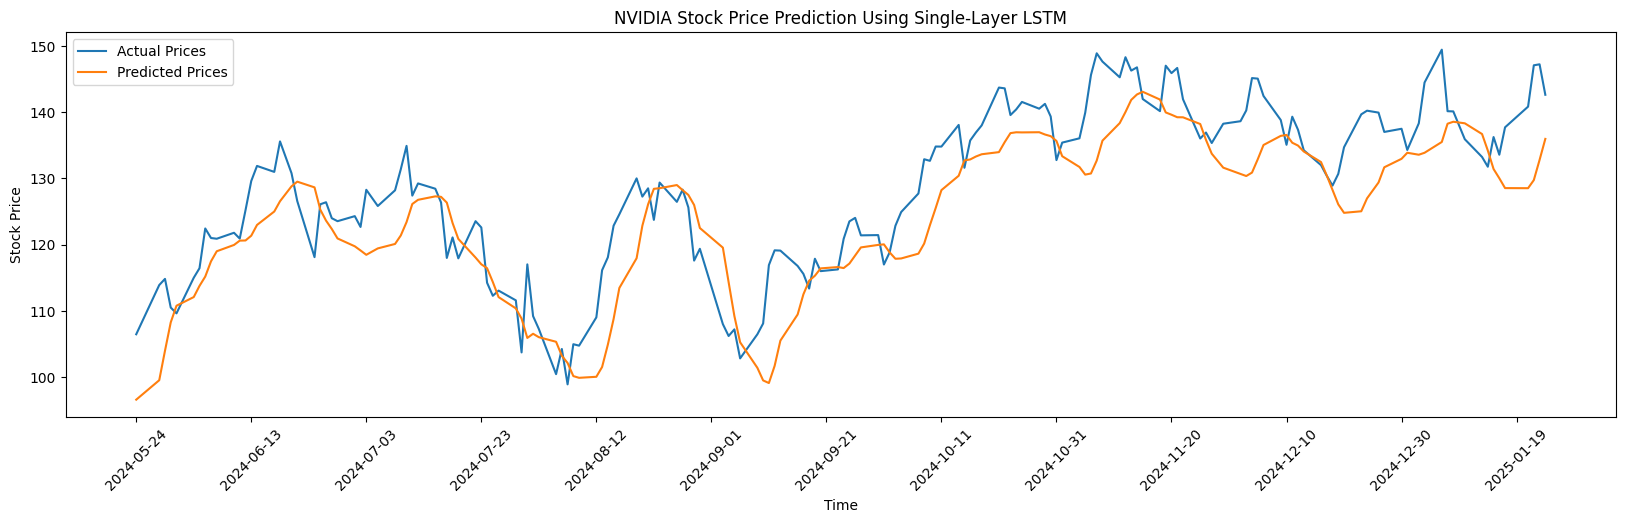

In [24]:
# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(test_dates, actual_prices_single_layer, label='Actual Prices')
plt.plot(test_dates, predicted_prices_single_layer, label='Predicted Prices')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))

plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.title('NVIDIA Stock Price Prediction Using Single-Layer LSTM')
plt.show()

In [25]:
# RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_single_layer, predicted_prices_single_layer))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 7.186769257070234


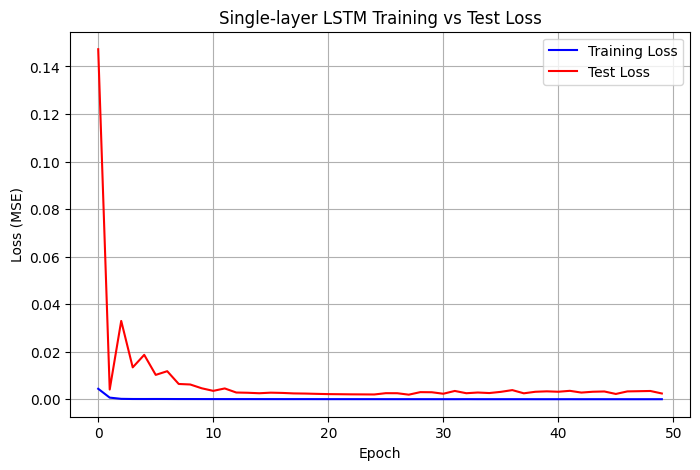

In [26]:
# Draw a comparison chart of training loss and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_single, label='Training Loss', color='blue')
plt.plot(test_loss_single, label='Test Loss', color='red')
plt.title('Single-layer LSTM Training vs Test Loss')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

## 3.2: Two-layer LSTM model

In [27]:
# Create LSTM two-layer model
model_two_layer = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(30, return_sequences=False),
    Dropout(0.3),
    Dense(15),
    Dense(1)
])

initial_learning_rate = 0.001
decay_rate = initial_learning_rate / 50
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Compile model
model_two_layer.compile(optimizer='adam', loss='mean_squared_error')

# Create callback for test set loss
test_callback_two = TestLossCallback((X_test, y_test))

# Add early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
history_two_layer = model_two_layer.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[test_callback_two],
    verbose=1
)

# Prediction
predicted_two_layer = model_two_layer.predict(X_test)

# Denormalization
predicted_prices_two_layer = scaler.inverse_transform(predicted_two_layer)
actual_prices_two_layer = scaler.inverse_transform(y_test.reshape(-1, 1))

# Record loss
train_loss_two = history_two_layer.history['loss']
test_loss_two = test_callback_two.test_losses

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 8.6499e-04 - val_loss: 0.0018
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 4.7812e-04 - val_loss: 7.6515e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 4.5363e-04 - val_loss: 0.0015
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - loss: 4.4283e-04 - val_loss: 0.0013
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 3.8663e-04 - val_loss: 0.0011
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 3.0695e-04 - val_loss: 0.0012
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 2.6962e-04 - val_loss: 0.0017
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 2.2515e-04 - val_loss: 7.7564e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 2.9187e-04 - val_loss: 5.6227e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 2.5509e-04 - val_loss: 0.0013
Epoch 12/50

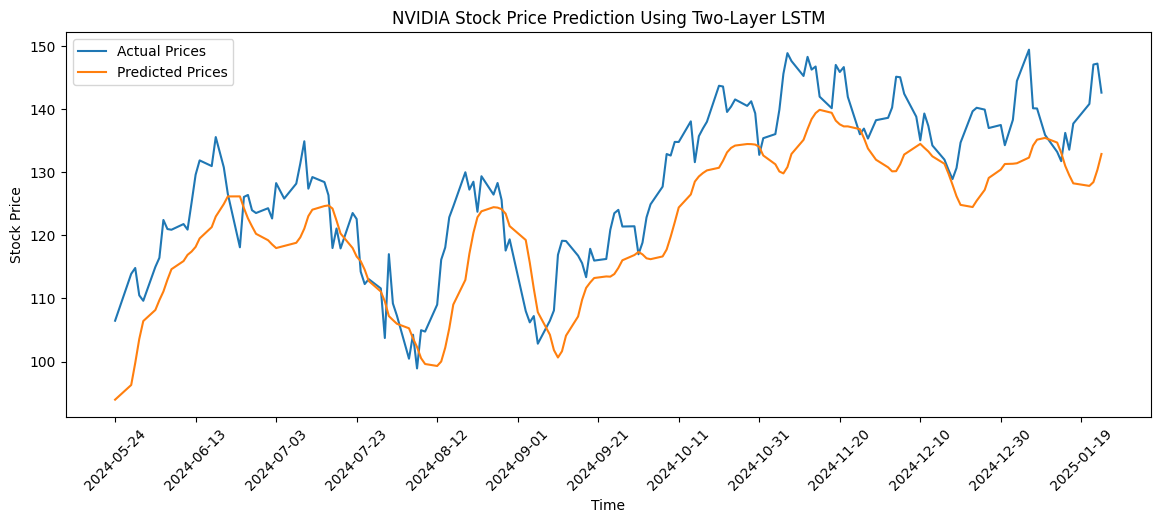

In [28]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_prices_two_layer, label='Actual Prices')
plt.plot(test_dates, predicted_prices_two_layer, label='Predicted Prices')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))

plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.title('NVIDIA Stock Price Prediction Using Two-Layer LSTM')
plt.show()

In [29]:
# RMSE
rmse_two_layer = np.sqrt(mean_squared_error(actual_prices_two_layer, predicted_prices_two_layer))
print(f"Root Mean Squared Error (RMSE): {rmse_two_layer}")

Root Mean Squared Error (RMSE): 8.711127998457634


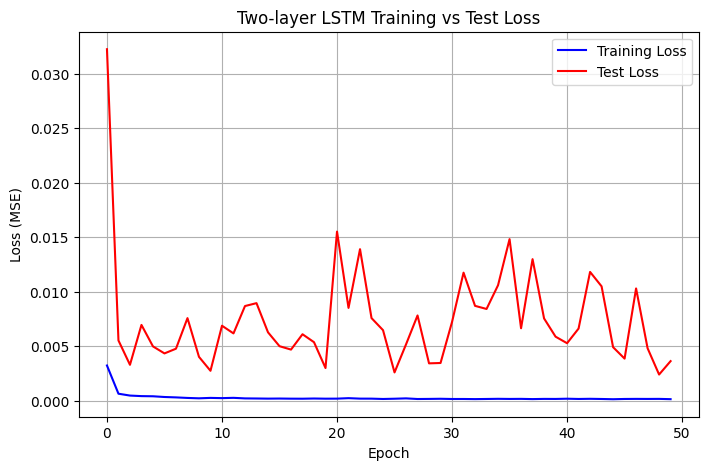

In [30]:
# Draw a comparison chart of training loss and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_two, label='Training Loss', color='blue')
plt.plot(test_loss_two, label='Test Loss', color='red')
plt.title('Two-layer LSTM Training vs Test Loss')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

## 3.3: RNN model

In [17]:
# Create RNN model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

model_RNN = Sequential([
    SimpleRNN(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

# Create callback for test set loss
test_callback_rnn = TestLossCallback((X_test, y_test))

# Train model
history_RNN = model_RNN.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[test_callback_rnn],
    verbose=1
)

# Prediction
predicted_RNN = model_RNN.predict(X_test)

# Denormalization
predicted_prices_RNN = scaler.inverse_transform(predicted_RNN)
actual_prices_RNN = scaler.inverse_transform(y_test.reshape(-1, 1))

# Record loss
train_loss_rnn = history_RNN.history['loss']
test_loss_rnn = test_callback_rnn.test_losses


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.2441 - val_loss: 0.0045
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0318 - val_loss: 0.0133
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0074 - val_loss: 0.0133
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0039 - val_loss: 0.0075
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss:

In [31]:
rmse_RNN = np.sqrt(mean_squared_error(actual_prices_two_layer, predicted_prices_two_layer))
print(f"Root Mean Squared Error (RMSE): {rmse_RNN}")

Root Mean Squared Error (RMSE): 8.711127998457634


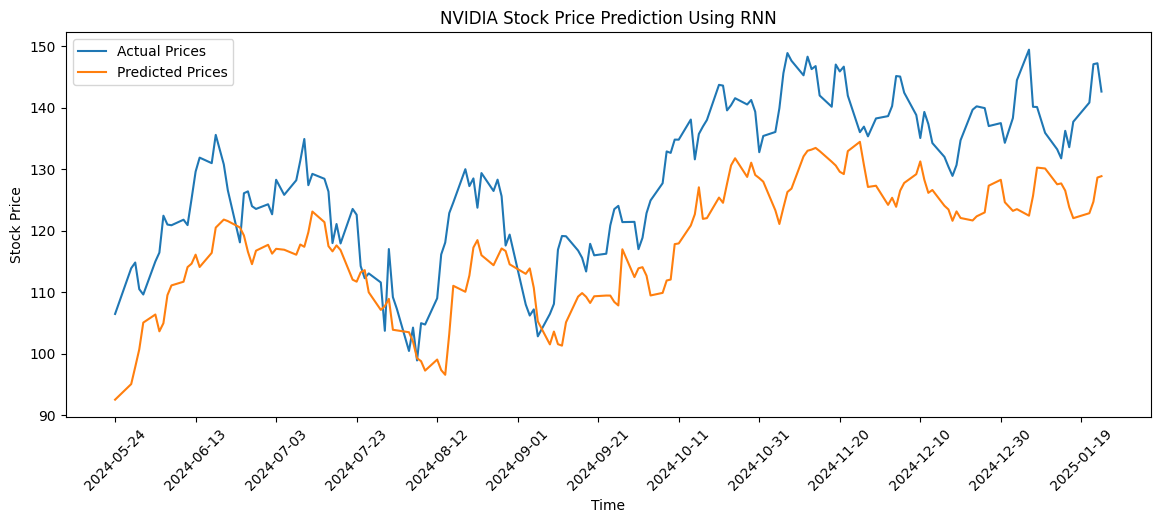

In [32]:
# Plot the results


plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_prices_RNN, label='Actual Prices')
plt.plot(test_dates, predicted_prices_RNN, label='Predicted Prices')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))


plt.legend()
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.title('NVIDIA Stock Price Prediction Using RNN')
plt.show()

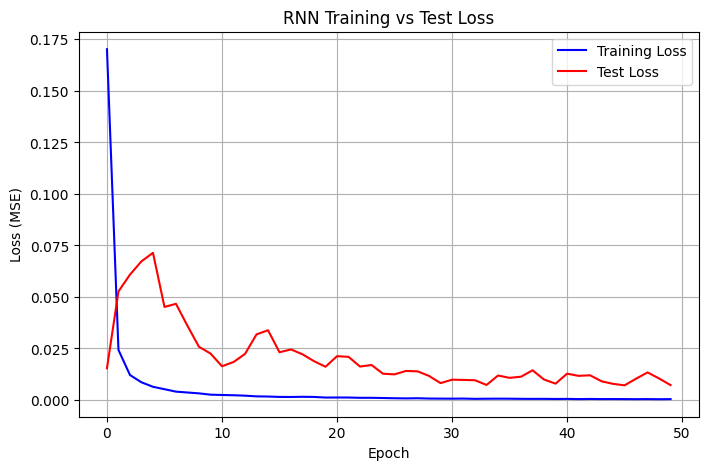

In [33]:
# Draw a comparison chart of training loss and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_rnn, label='Training Loss', color='blue')
plt.plot(test_loss_rnn, label='Test Loss', color='red')
plt.title('RNN Training vs Test Loss')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

## 3.4: GRU model

In [35]:
# Create GRU model
from tensorflow.keras.layers import GRU, Dense, Dropout
model_GRU = Sequential([
    GRU(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile model
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Create callback for test set loss
test_callback_gru = TestLossCallback((X_test, y_test))

# Train model
history_GRU = model_GRU.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[test_callback_gru],
    verbose=1
)

# Prediction
predicted_GRU = model_GRU.predict(X_test)

# Denormalization
predicted_prices_GRU = scaler.inverse_transform(predicted_GRU)
actual_prices_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

# Record loss
train_loss_gru = history_GRU.history['loss']
test_loss_gru = test_callback_gru.test_losses

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - loss: 0.0083 - val_loss: 0.0549
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0018 - val_loss: 0.0161
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 4.9607e-04 - val_loss: 6.7921e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 9.1424e-05 - val_loss: 4.1004e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 7.1993e-05 - val_loss: 4.6555e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 7.4847e-05 - val_loss: 3.8524e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 6.4054e-05 - val_loss: 3.7422e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 6.1452e-05 - val_loss: 3.6510e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 6.0128e-05 - val_loss: 3.4612e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 6.5811e-05 - val_loss: 3.5433e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 5.8138e-05 - val_loss: 3.

In [36]:
rmse_GRU = np.sqrt(mean_squared_error(actual_prices_GRU, predicted_prices_GRU))
print(f"Root Mean Squared Error (RMSE): {rmse_GRU}")

Root Mean Squared Error (RMSE): 5.367712047069056


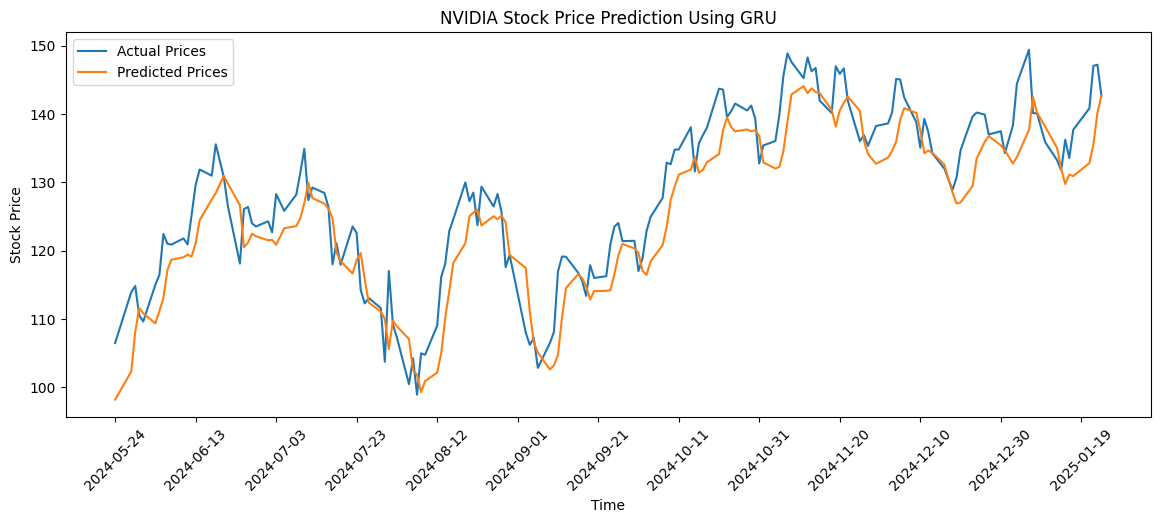

In [37]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_prices_GRU, label='Actual Prices')
plt.plot(test_dates, predicted_prices_GRU, label='Predicted Prices')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))


plt.legend()
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.title('NVIDIA Stock Price Prediction Using GRU')
plt.show()

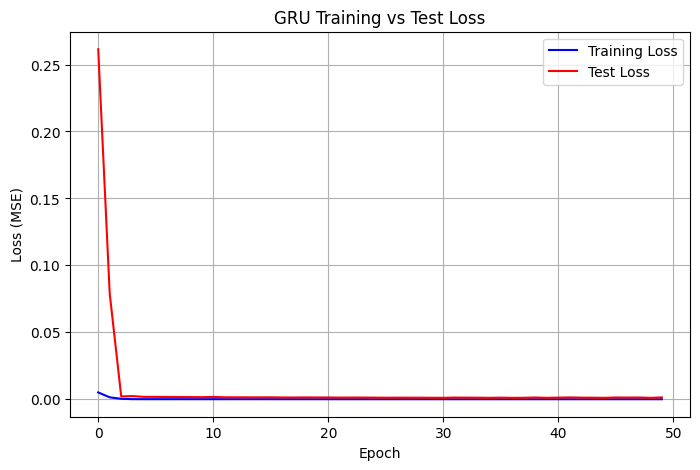

In [38]:
# Draw a comparison chart of training loss and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_gru, label='Training Loss', color='blue')
plt.plot(test_loss_gru, label='Test Loss', color='red')
plt.title('GRU Training vs Test Loss')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



# step 4: Calculate the RMSE, MAE, and MAPEi of the four models

In [40]:
# Single-layer LSTM evaluation
rmse_single = np.sqrt(mean_squared_error(actual_prices_single_layer, predicted_prices_single_layer))
mae_single = mean_absolute_error(actual_prices_single_layer, predicted_prices_single_layer)
mape_single = mean_absolute_percentage_error(actual_prices_single_layer, predicted_prices_single_layer)

print("Single Layer LSTM Performance Metrics:")
print(f"RMSE: {rmse_single:.2f}")
print(f"MAE: {mae_single:.2f}")
print(f"MAPE: {mape_single:.2f}%")
print("-" * 50)



Single Layer LSTM Performance Metrics:
RMSE: 7.19
MAE: 5.71
MAPE: 4.43%
--------------------------------------------------


In [41]:
# Two-layer LSTM evaluation
rmse_two_layer = np.sqrt(mean_squared_error(actual_prices_two_layer, predicted_prices_two_layer))
mae_two_layer = mean_absolute_error(actual_prices_two_layer, predicted_prices_two_layer)
mape_two_layer = mean_absolute_percentage_error(actual_prices_two_layer, predicted_prices_two_layer)

print("Two Layer LSTM Performance Metrics:")
print(f"RMSE: {rmse_two_layer:.2f}")
print(f"MAE: {mae_two_layer:.2f}")
print(f"MAPE: {mape_two_layer:.2f}%")
print("-" * 50)



Two Layer LSTM Performance Metrics:
RMSE: 8.71
MAE: 7.26
MAPE: 5.62%
--------------------------------------------------


In [42]:
# RNN evaluation
rmse_rnn = np.sqrt(mean_squared_error(actual_prices_RNN, predicted_prices_RNN))
mae_rnn = mean_absolute_error(actual_prices_RNN, predicted_prices_RNN)
mape_rnn = mean_absolute_percentage_error(actual_prices_RNN, predicted_prices_RNN)

print("RNN Performance Metrics:")
print(f"RMSE: {rmse_rnn:.2f}")
print(f"MAE: {mae_rnn:.2f}")
print(f"MAPE: {mape_rnn:.2f}%")
print("-" * 50)



RNN Performance Metrics:
RMSE: 12.30
MAE: 10.94
MAPE: 8.37%
--------------------------------------------------


In [43]:
# GRU evaluation
rmse_gru = np.sqrt(mean_squared_error(actual_prices_GRU, predicted_prices_GRU))
mae_gru = mean_absolute_error(actual_prices_GRU, predicted_prices_GRU)
mape_gru = mean_absolute_percentage_error(actual_prices_GRU, predicted_prices_GRU)

print("GRU Performance Metrics:")
print(f"RMSE: {rmse_gru:.2f}")
print(f"MAE: {mae_gru:.2f}")
print(f"MAPE: {mape_gru:.2f}%")

GRU Performance Metrics:
RMSE: 5.37
MAE: 4.36
MAPE: 3.42%


# step 5: Results Visualization

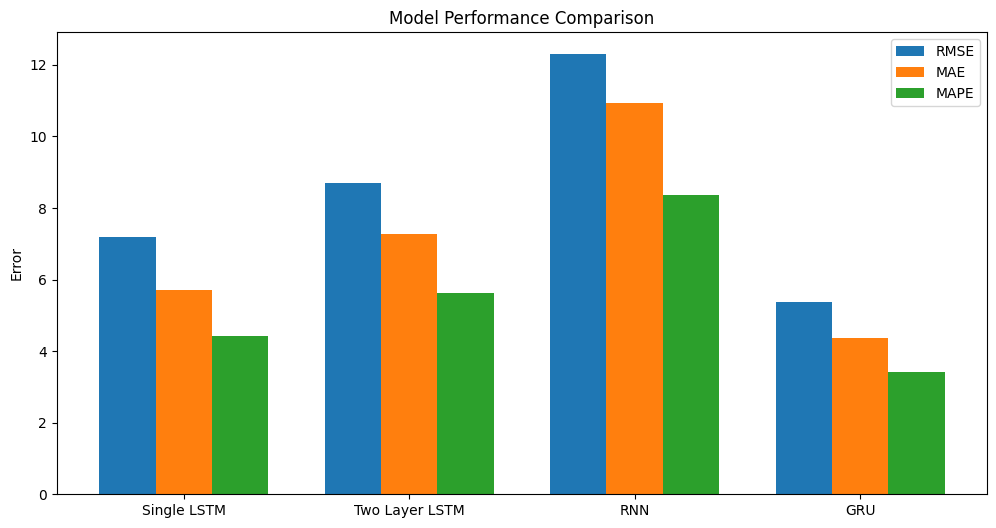

In [44]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Single LSTM', 'Two Layer LSTM', 'RNN', 'GRU']
rmse_scores = [rmse_single, rmse_two_layer, rmse_rnn, rmse_gru]
mae_scores = [mae_single, mae_two_layer, mae_rnn, mae_gru]
mape_scores = [mape_single, mape_two_layer, mape_rnn, mape_gru]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, rmse_scores, width, label='RMSE')
rects2 = ax.bar(x, mae_scores, width, label='MAE')
rects3 = ax.bar(x + width, mape_scores, width, label='MAPE')

ax.set_ylabel('Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

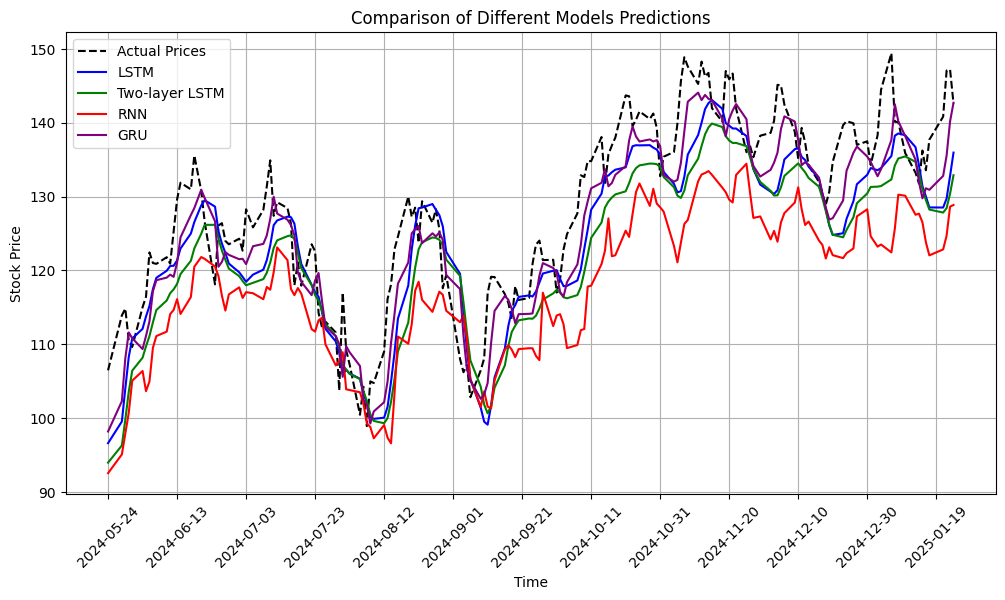

In [48]:
# Comparison chart of model prediction results
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices_single_layer, label='Actual Prices', color='black', linestyle='dashed')
plt.plot(test_dates, predicted_prices_single_layer, label='LSTM', color='blue')
plt.plot(test_dates, predicted_prices_two_layer, label='Two-layer LSTM', color='green')
plt.plot(test_dates, predicted_prices_RNN, label='RNN', color='red')
plt.plot(test_dates, predicted_prices_GRU, label='GRU', color='purple')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Comparison of Different Models Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

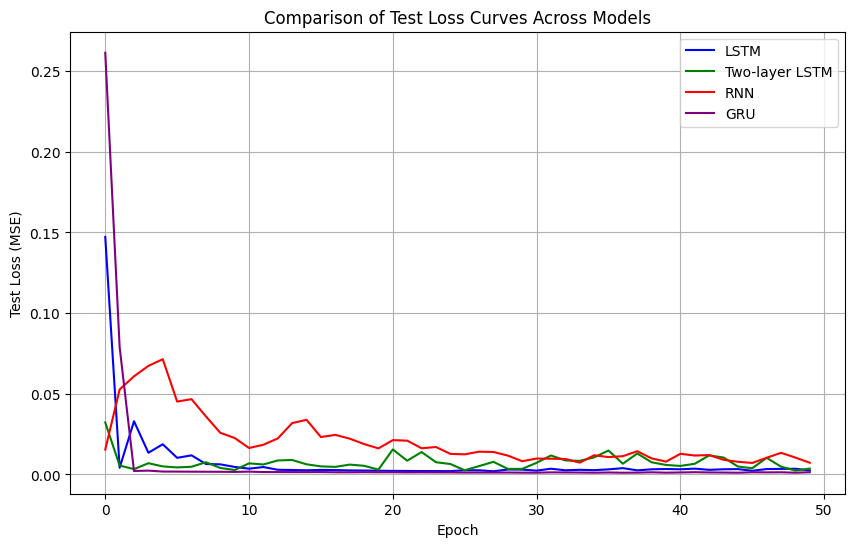

In [46]:
# Draw a comparison chart of the test loss of all models
plt.figure(figsize=(10, 6))
plt.plot(test_loss_single, label='LSTM', color='blue')
plt.plot(test_loss_two, label='Two-layer LSTM', color='green')
plt.plot(test_loss_rnn, label='RNN', color='red')
plt.plot(test_loss_gru, label='GRU', color='purple')

plt.title('Comparison of Test Loss Curves Across Models')
plt.xlabel('Epoch')
plt.ylabel('Test Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
